<a href="https://colab.research.google.com/github/dahliajones24/Abbreviation_Generator/blob/main/Copy_of_Machine_Learning_Assignment_(PneumoniaMNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries

In [ ]:
!pip install medmnist

In [ ]:
!pip install tqdm

In [ ]:
!pip install torchsummary

In [ ]:
import medmnist
from medmnist.info import INFO
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

  Importing MedMINIST Dataset
  

In [ ]:
from medmnist import PneumoniaMNIST, BloodMNIST
help(PneumoniaMNIST)

Help on class PneumoniaMNIST in module medmnist.dataset:

class PneumoniaMNIST(MedMNIST2D)
 |  PneumoniaMNIST(split, transform=None, target_transform=None, download=False, as_rgb=False, root='/root/.medmnist', size=None, mmap_mode=None)
 |  
 |  Method resolution order:
 |      PneumoniaMNIST
 |      MedMNIST2D
 |      MedMNIST
 |      torch.utils.data.dataset.Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  __parameters__ = ()
 |  
 |  flag = 'pneumoniamnist'
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from MedMNIST2D:
 |  
 |  __getitem__(self, index)
 |      return: (without transform/target_transofrm)
 |          img: PIL.Image
 |          target: np.array of `L` (L=1 for single-label)
 |  
 |  montage(self, length=20, replace=False, save_folder=None)
 |  
 |  save(self, folder, postfix='png', write_csv=True)
 |  
 |  --------------


Preparing the 2D dataset (PneumoniaMNIST) with size 28x28

In [ ]:
# Setup for pneumoniaMNIST
data_flag = 'pneumoniamnist'
download = True

# Constants
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

# Dataset specific information
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])  # Should be 2 for binary classification

DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate data into DataLoader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 4170669/4170669 [00:00<00:00, 4773729.17it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pne

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


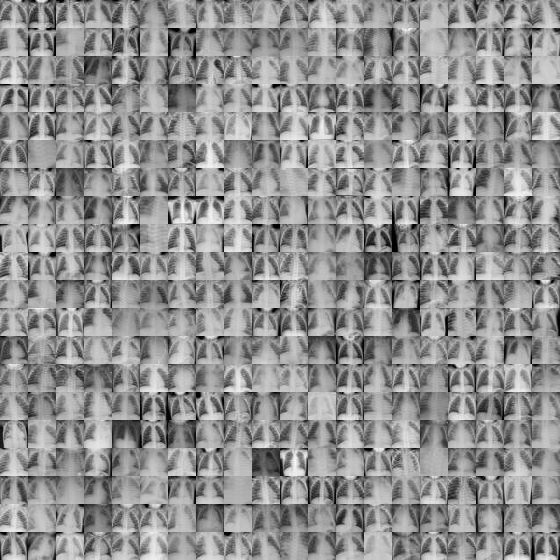

In [ ]:
# visualization

train_dataset.montage(length=20)

Initialising the model. Setting up the 'Net' Class

In [ ]:
# Define a simple CNN model adapted for binary classification
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        # Define the layers as before
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Adjust the fully connected layer for binary classification
        # This will now output a single value
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1))  # Output single logit for binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=1)  # num_classes is 1 for binary

# Define loss function and optimizer for binary classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


Train and Evaluate Pnuemonia Datasets

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader):  # Iterate over the training data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Get model outputs

        # Since this is a binary classification task, ensure targets are of the correct type
        targets = targets.to(torch.float32).view(-1, 1)  # Adjust shape if necessary for your model/criterion
        loss = criterion(outputs, targets)  # Compute the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        # Optional: Calculate accuracy within the loop if desired
        predicted = torch.sigmoid(outputs).round()  # Assuming your model ends with a linear layer and you're using BCEWithLogitsLoss, remove torch.sigmoid if using BCEWithLogitsLoss
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        train_loss += loss.item() * inputs.size(0)

    # Calculate average loss and accuracy over the epoch
    epoch_loss = train_loss / train_total
    epoch_acc = train_correct / train_total * 100

    # Print training loss and accuracy for the epoch
    print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')


100%|██████████| 37/37 [00:09<00:00,  3.82it/s]


Epoch 1: Train Loss: 0.6130, Train Accuracy: 74.21%


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 2: Train Loss: 0.4279, Train Accuracy: 78.36%


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]

Epoch 3: Train Loss: 0.2622, Train Accuracy: 91.76%


Loss Function and Optimizer

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
import torch

def test(split):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_score = []

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():  # Instruct PyTorch to not compute gradients
        for inputs, targets in data_loader:
            inputs = inputs.to(device)  # Ensure inputs are on the correct device
            outputs = model(inputs)

            # For binary classification, use sigmoid and flatten the output
            outputs = torch.sigmoid(outputs).squeeze()  # Assuming output is a single value per example

            # Flatten the targets and outputs and extend the lists
            y_true.extend(targets.cpu().numpy().flatten().tolist())  # Flatten and convert to list
            y_score.extend(outputs.cpu().detach().numpy().flatten().tolist())  # Flatten and convert to list

    # Now, y_true and y_score should be lists of floats/ints
    auc = roc_auc_score(y_true, y_score)
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]
    acc = accuracy_score(y_true, y_pred)

    print(f'{split} AUC: {auc:.3f} Accuracy: {acc:.3f}')

print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train AUC: 0.983 Accuracy: 0.935
test AUC: 0.946 Accuracy: 0.806


In [ ]:
# Correctly instantiate the model with required arguments
model = Net(in_channels=1, num_classes=1)

# Move the model instance to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use the summary function to display the model summary, including parameters
from torchsummary import summary
summary(model, (1, 28, 28))  # Assuming input size is 1x28x28


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,320
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 64, 10, 10]           9,280
       BatchNorm2d-9           [-1, 64, 10, 10]             128
             ReLU-10           [-1, 64, 10, 10]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

DenseNet Model Dataset

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, in_features, num_classes):
        super(DenseNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Another Dropout layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # Apply dropout
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Instantiate the model
model_dense = DenseNet(in_features=28*28, num_classes=1).to(device)

# Use the same criterion and optimizer as before
criterion_dense = nn.BCEWithLogitsLoss()
optimizer_dense = optim.SGD(model_dense.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
optimizer_dense_adam = optim.Adam(model_dense.parameters(), lr=0.0001)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, device, num_epochs=NUM_EPOCHS):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, targets in tqdm(train_loader):  # Iterate over the training data
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the images for the dense network
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Get model outputs

            targets = targets.to(torch.float32).view(-1, 1)  # Adjust targets shape
            loss = criterion(outputs, targets)  # Compute the loss

            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters

            predicted = torch.sigmoid(outputs).round()  # Prediction
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
            train_loss += loss.item() * inputs.size(0)

        epoch_loss = train_loss / train_total
        epoch_acc = train_correct / train_total * 100
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_score = []

    with torch.no_grad():  # Instruct PyTorch to not compute gradients
        for inputs, targets in data_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the images for the dense network
            inputs = inputs.to(device)  # Ensure inputs are on the correct device
            outputs = model(inputs)

            outputs = torch.sigmoid(outputs).squeeze()  # Assuming output is a single value per example

            y_true.extend(targets.cpu().numpy().flatten().tolist())
            y_score.extend(outputs.cpu().detach().numpy().flatten().tolist())

    auc = roc_auc_score(y_true, y_score)
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]
    acc = accuracy_score(y_true, y_pred)

    print(f'AUC: {auc:.3f} Accuracy: {acc:.3f}')


In [ ]:
print('Training Dense Model...')
train_model(model_dense, criterion_dense, optimizer_dense_adam, train_loader, device, NUM_EPOCHS)

print('Evaluating Dense Model on Training Set...')
evaluate_model(model_dense, train_loader, device)

print('Evaluating Dense Model on Test Set...')
evaluate_model(model_dense, test_loader, device)

Training Dense Model...


100%|██████████| 37/37 [00:01<00:00, 23.05it/s]


Epoch 1/3: Train Loss: 0.5679, Train Accuracy: 73.70%


100%|██████████| 37/37 [00:01<00:00, 18.67it/s]


Epoch 2/3: Train Loss: 0.3290, Train Accuracy: 89.08%


100%|██████████| 37/37 [00:02<00:00, 18.25it/s]


Epoch 3/3: Train Loss: 0.2068, Train Accuracy: 92.74%
Evaluating Dense Model on Training Set...
AUC: 0.979 Accuracy: 0.936
Evaluating Dense Model on Test Set...
AUC: 0.918 Accuracy: 0.849


Deep Network

In [ ]:
# Enhanced Data Augmentation
data_transform= transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

BATCH_SIZE = 128
train_loader_augmented = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
# CustomNet Model
class CustomNet(nn.Module):
    def __init__(self, in_channels):
        super(CustomNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_custom = CustomNet(in_channels=n_channels).to(device)

In [ ]:
criterion_custom = nn.BCEWithLogitsLoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001)

In [ ]:
# Training and Evaluation Functions
def train_model(model, criterion, optimizer, train_loader, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.to(torch.float32).view(-1, 1)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            predicted = torch.sigmoid(outputs).round()
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
            train_loss += loss.item() * inputs.size(0)

        epoch_loss = train_loss / train_total
        epoch_acc = train_correct / train_total * 100
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            outputs = torch.sigmoid(outputs).squeeze()

            y_true.extend(targets.cpu().numpy().flatten().tolist())
            y_score.extend(outputs.cpu().detach().numpy().flatten().tolist())

    auc = roc_auc_score(y_true, y_score)
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]
    acc = accuracy_score(y_true, y_pred)

    print(f'AUC: {auc:.3f} Accuracy: {acc:.3f}')

In [ ]:
# Training and Evaluation Execution
NUM_EPOCHS = 3
print('Training Custom Deep Model...')
train_model(model_custom, criterion_custom, optimizer_custom, train_loader_augmented, device, NUM_EPOCHS)

print('Evaluating Custom Deep Model on Training Set...')
evaluate_model(model_custom, train_loader_augmented, device)

print('Evaluating Custom Deep Model on Test Set...')
evaluate_model(model_custom, test_loader, device)

Training Custom Deep Model...


100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


Epoch 1/3: Train Loss: 0.4364, Train Accuracy: 81.75%


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 2/3: Train Loss: 0.1835, Train Accuracy: 92.50%


100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Epoch 3/3: Train Loss: 0.1472, Train Accuracy: 94.82%
Evaluating Custom Deep Model on Training Set...
AUC: 0.993 Accuracy: 0.965
Evaluating Custom Deep Model on Test Set...
AUC: 0.937 Accuracy: 0.832
